In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import random
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import matthews_corrcoef, r2_score, mean_squared_error, f1_score, fbeta_score
from sklearn import preprocessing
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier, CatBoostRegressor

from rgf.sklearn import RGFClassifier, RGFRegressor
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.svm import SVC, SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from math import sqrt
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
os.chdir(r'/Users/gympohnpimol/Desktop/Hackathons_ML')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
train.head(10)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
5,58896,Analytics,region_2,Bachelor's,m,sourcing,2,31,3.0,7,0,0,85,0
6,20379,Operations,region_20,Bachelor's,f,other,1,31,3.0,5,0,0,59,0
7,16290,Operations,region_34,Master's & above,m,sourcing,1,33,3.0,6,0,0,63,0
8,73202,Analytics,region_20,Bachelor's,m,other,1,28,4.0,5,0,0,83,0
9,28911,Sales & Marketing,region_1,Master's & above,m,sourcing,1,32,5.0,5,1,0,54,0


In [3]:
train_original=train.copy() 
test_original=test.copy()

In [4]:
test.head(10)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61
5,46232,Procurement,region_7,Bachelor's,m,sourcing,1,36,3.0,2,0,0,68
6,54542,Finance,region_2,Bachelor's,m,other,1,33,5.0,3,1,0,57
7,67269,Analytics,region_22,Bachelor's,m,sourcing,2,36,3.0,3,0,0,85
8,66174,Technology,region_7,Master's & above,m,other,1,51,4.0,11,0,0,75
9,76303,Technology,region_22,Bachelor's,m,sourcing,1,29,5.0,2,1,0,76


In [5]:
sub.head(5)

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [6]:
train.shape
test.shape

(54808, 14)

(23490, 13)

In [7]:
for i in train.columns:
    print(i, train[i].unique())

employee_id [65438 65141  7513 ... 13918 13614 51526]
department ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
region ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18']
education ["Master's & above" "Bachelor's" nan 'Below Secondary']
gender ['f' 'm']
recruitment_channel ['sourcing' 'other' 'referred']
no_of_trainings [ 1  2  3  4  7  5  6  8 10  9]
age [35 30 34 39 45 31 33 28 32 49 37 38 41 27 29 26 24 57 40 42 23 59 44 50
 56 20 25 47 36 46 60 43 22 54 58 48 53 55 51 52 21]
previous_year_rating [ 5.  3.  1.  4. nan  2.]
length_of_service [ 8  4  7 10  2  5  6  1  3 16  9 11 26 

In [8]:
train["education"].replace(np.nan, "Bachelor's", inplace = True)
test["education"].replace(np.nan, "Bachelor's", inplace = True)

train["education"].replace("Master's & above", 3, inplace = True)
test["education"].replace("Master's & above", 3, inplace = True)
train["education"].replace("Bachelor's", 2, inplace = True)
test["education"].replace("Bachelor's", 2, inplace = True)
train["education"].replace("Below Secondary", 1, inplace = True)
test["education"].replace("Below Secondary", 1, inplace = True)

train["previous_year_rating"].replace(np.nan, 3., inplace = True)
test["previous_year_rating"].replace(np.nan, 3., inplace = True)

In [9]:
train["sum_metric"] = train["awards_won?"] + train["KPIs_met >80%"] + train["previous_year_rating"]
test["sum_metric"] = train["awards_won?"] + test["KPIs_met >80%"] + test["previous_year_rating"]

In [10]:
train["total_s"] = train["avg_training_score"] * train["no_of_trainings"]
test["total_s"] = test["avg_training_score"] * test["no_of_trainings"]

In [11]:
train[train["is_promoted"] == 1].groupby("previous_year_rating")["is_promoted"].count()
train.groupby("previous_year_rating")["is_promoted"].count()

previous_year_rating
1.0      88
2.0     181
3.0    1694
4.0     784
5.0    1921
Name: is_promoted, dtype: int64

previous_year_rating
1.0     6223
2.0     4225
3.0    22742
4.0     9877
5.0    11741
Name: is_promoted, dtype: int64

In [12]:
train.isna().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
sum_metric              0
total_s                 0
dtype: int64

In [13]:
test.isna().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
sum_metric              0
total_s                 0
dtype: int64

In [14]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted', 'sum_metric', 'total_s'],
      dtype='object')

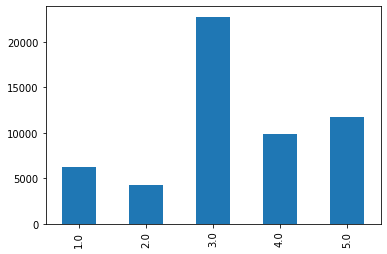

In [15]:
train["previous_year_rating"].value_counts().sort_index().head(50).plot.bar()

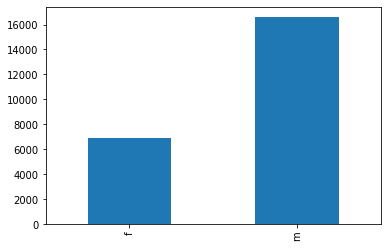

In [16]:
test["gender"].value_counts().sort_index().head(20).plot.bar()

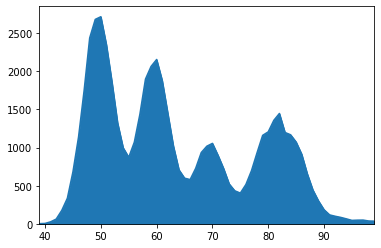

In [17]:
train["avg_training_score"].value_counts().sort_index().plot.area()

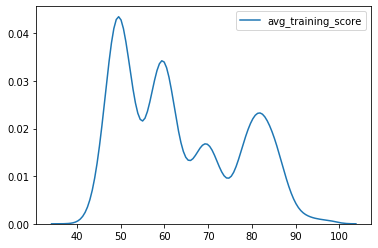

In [18]:
sns.kdeplot(train["avg_training_score"])

In [19]:
test.isnull().sum().sum()

0

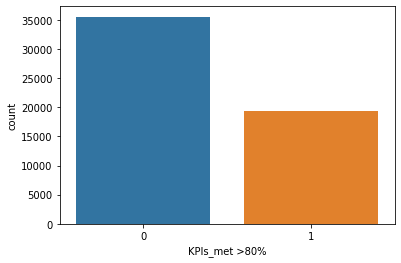

In [20]:
sns.countplot(train["KPIs_met >80%"])

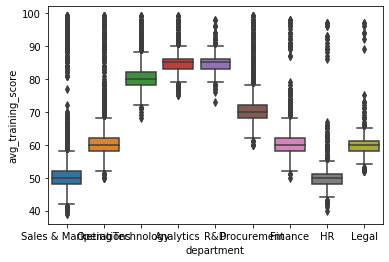

In [21]:
df = train[train.department.isin(train.department.value_counts().head(10).index)]
sns.boxplot(x = "department", y = "avg_training_score", data = df)

In [22]:
le = preprocessing.LabelEncoder()

train["department"] = le.fit_transform(train["department"])
test["department"] = le.transform(test["department"])
test

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,sum_metric,total_s
0,8724,8,region_26,2,m,sourcing,1,24,3.0,1,1,0,77,4.0,77
1,74430,2,region_4,2,f,other,1,31,3.0,5,0,0,51,3.0,51
2,72255,7,region_13,2,m,other,1,31,1.0,4,0,0,47,1.0,47
3,38562,5,region_2,2,f,other,3,31,2.0,9,0,0,65,2.0,195
4,64486,1,region_29,2,m,sourcing,1,30,4.0,7,0,0,61,4.0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,53478,3,region_2,1,m,sourcing,1,24,3.0,1,0,0,61,3.0,61
23486,25600,8,region_25,2,m,sourcing,1,31,3.0,7,0,0,74,3.0,74
23487,45409,2,region_16,2,f,sourcing,1,26,4.0,4,0,0,50,4.0,50
23488,1186,5,region_31,2,m,sourcing,3,27,3.0,1,0,0,70,3.0,210


In [23]:
train["region"] = le.fit_transform(train["region"])
test["region"] = le.transform(test["region"])

train["gender"] = le.fit_transform(train["gender"])
test["gender"] = le.transform(test["gender"])

train["recruitment_channel"] = le.fit_transform(train["recruitment_channel"])
test["recruitment_channel"] = le.transform(test["recruitment_channel"])

In [24]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_s
0,65438,7,31,3,0,2,1,35,5.0,8,1,0,49,0,6.0,49
1,65141,4,14,2,1,0,1,30,5.0,4,0,0,60,0,5.0,60
2,7513,7,10,2,1,2,1,34,3.0,7,0,0,50,0,3.0,50
3,2542,7,15,2,1,0,2,39,1.0,10,0,0,50,0,1.0,100
4,48945,8,18,2,1,0,1,45,3.0,2,0,0,73,0,3.0,73


In [25]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,sum_metric,total_s
0,8724,8,18,2,1,2,1,24,3.0,1,1,0,77,4.0,77
1,74430,2,28,2,0,0,1,31,3.0,5,0,0,51,3.0,51
2,72255,7,4,2,1,0,1,31,1.0,4,0,0,47,1.0,47
3,38562,5,11,2,0,0,3,31,2.0,9,0,0,65,2.0,195
4,64486,1,21,2,1,2,1,30,4.0,7,0,0,61,4.0,61


In [26]:
y1 = train["is_promoted"]
train1 = train.drop(["employee_id", "is_promoted", "recruitment_channel"], axis = 1)
train1 = train1.values
y = y1.values

test_id = test["employee_id"]
test1 = test.drop(["employee_id", "recruitment_channel"], axis = 1)
test1 = test1.values

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train1)
train2 = scaler.transform(train1)
test2 = scaler.transform(test1)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
pca = PCA(n_components = 1)
pca.fit(train2)
train_pca = pca.transform(train2)
test_pca = pca.transform(test2)
train3 = np.column_stack((train2, train_pca))
test3 = np.column_stack((test2, test_pca))

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [29]:
enc = OneHotEncoder()
enc.fit(train1)
train2_one = enc.transform(train1)
test2_one = enc.transform(test1)

pca = PCA(n_components=1)
pca.fit(train2_one.toarray())
train_pca = pca.transform(train2_one.toarray())
test_pca = pca.transform(test2_one.toarray())
train3=np.column_stack((train2,train_pca))
test3=np.column_stack((test2,test_pca))

/Users/gympohnpimol/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

,principal component 1,principal component 2,is_promoted
0,2.178611,-1.730127,0
1,1.069615,-0.016497,0
2,-1.081079,-0.859902,0
3,-3.025369,0.274200,0
4,-0.895361,-0.244505,0


Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, '2 Component PCA')

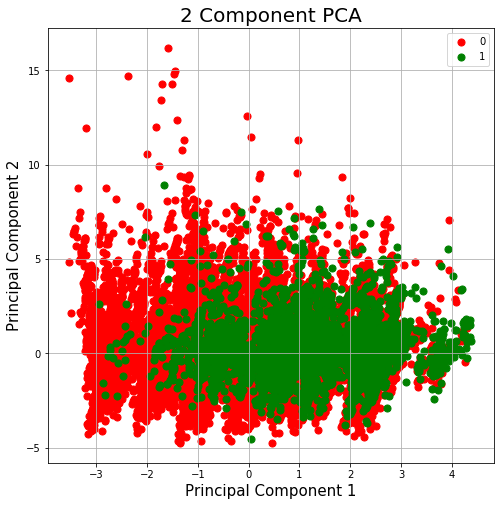

In [30]:
pca = PCA(n_components = 2)
principal_component = pca.fit_transform(train2)
principal_df = pd.DataFrame(data = principal_component, columns = ["principal component 1", "principal component 2"])

final_df = pd.concat([principal_df, train.is_promoted], axis = 1)
final_df.head(5)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Principal Component 1", fontsize = 15)
ax.set_ylabel("Principal Component 2", fontsize = 15)
ax.set_title("2 Component PCA", fontsize = 20)

targets = [0,1]
colors = ["r", "g"]
for target, color in zip(targets, colors):
    indicesToKeep = final_df["is_promoted"] == target
    ax.scatter(final_df.loc[indicesToKeep, "principal component 1"],
               final_df.loc[indicesToKeep, "principal component 2"],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

In [31]:
pca = PCA(n_components = 1)
pca.fit(train2)
train_pca = pca.transform(train2)
test_pca = pca.transform(test2)
train3 = np.column_stack((train2, train_pca))
test3 = np.column_stack((test2, test_pca))

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [32]:
train3.shape

(54808, 14)

In [33]:
train

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_s
0,65438,7,31,3,0,2,1,35,5.0,8,1,0,49,0,6.0,49
1,65141,4,14,2,1,0,1,30,5.0,4,0,0,60,0,5.0,60
2,7513,7,10,2,1,2,1,34,3.0,7,0,0,50,0,3.0,50
3,2542,7,15,2,1,0,2,39,1.0,10,0,0,50,0,1.0,100
4,48945,8,18,2,1,0,1,45,3.0,2,0,0,73,0,3.0,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,8,5,2,1,2,1,48,3.0,17,0,0,78,0,3.0,78
54804,74592,4,19,3,0,0,1,37,2.0,6,0,0,56,0,2.0,56
54805,13918,0,0,2,1,0,1,27,5.0,3,1,0,79,0,6.0,79
54806,13614,7,33,2,1,2,1,29,1.0,2,0,0,45,0,1.0,45


In [34]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,sum_metric,total_s
0,8724,8,18,2,1,2,1,24,3.0,1,1,0,77,4.0,77
1,74430,2,28,2,0,0,1,31,3.0,5,0,0,51,3.0,51
2,72255,7,4,2,1,0,1,31,1.0,4,0,0,47,1.0,47
3,38562,5,11,2,0,0,3,31,2.0,9,0,0,65,2.0,195
4,64486,1,21,2,1,2,1,30,4.0,7,0,0,61,4.0,61


In [43]:
train=train.drop('employee_id',axis=1) 
test=test.drop('employee_id',axis=1)

In [44]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_s
0,7,31,3,0,2,1,35,5.0,8,1,0,49,0,6.0,49
1,4,14,2,1,0,1,30,5.0,4,0,0,60,0,5.0,60
2,7,10,2,1,2,1,34,3.0,7,0,0,50,0,3.0,50
3,7,15,2,1,0,2,39,1.0,10,0,0,50,0,1.0,100
4,8,18,2,1,0,1,45,3.0,2,0,0,73,0,3.0,73


In [45]:
y = train.is_promoted
x = train.drop('is_promoted',1)
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: is_promoted, dtype: int64

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1234)
LR = LogisticRegression()
LR.fit(x_train, y_train)
pred_test = LR.predict(x_test)

/Users/gympohnpimol/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
f1_score(y_test, pred_test)

0.103921568627451

In [48]:
pred_df = LR.predict(test)
pred_df

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
submission = pd.read_csv("sample_submission_M0L0uXE.csv")
submission

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0


In [50]:
submission['is_promoted'] = pred_df
submission['employee_id'] = test_original['employee_id']

In [51]:
submission['is_promoted'].value_counts()

0    23387
1      103
Name: is_promoted, dtype: int64